In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import numba as nb
from numba import cuda

In [24]:
def seq_with_plotting(pixelsMatrix,mask,grayLevels = 256):
    H,W = pixelsMatrix.shape
    size = H*W
    occurencies = [0.0 for _ in range(grayLevels)]
    occurencies_for_plot = [0.0 for _ in range(grayLevels)]
    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):
            if  mask[row_id][pixel_id]==0:
                occurencies[pixel]+=1
            occurencies_for_plot[pixel]+=1
    cdf = [sum(occurencies[:i+1]) for i in range(grayLevels)]
    cdfmin = next((x for x in cdf if x),-1)
    h = [round((cdf[v]-cdfmin)/(size-cdfmin) * (grayLevels-1)) for v in range(grayLevels)]

    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):

            if  mask[row_id][pixel_id]==0:
                pixelsMatrix[row_id][pixel_id] = h[pixel]
            

    occurrencies_equalized = [0.0 for _ in range(grayLevels)]

    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):
            if mask is None or mask[row_id][pixel_id]==0:


                occurrencies_equalized[pixel]+=1


    plt.bar(range(grayLevels),occurrencies_equalized,label = 'equalized')
    plt.bar(range(grayLevels),occurencies_for_plot,label = 'original')
    plt.legend()
    return Image.fromarray(pixelsMatrix)


In [25]:
def sequential(pixelsMatrix,mask,grayLevels = 256) -> np.ndarray:
    H,W = pixelsMatrix.shape
    assert  mask.shape==pixelsMatrix.shape,"Invalid mask size"
    size = H*W
    occurencies = [0.0 for _ in range(grayLevels)]
    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):
            if  mask[row_id][pixel_id]==0:
                occurencies[pixel]+=1

    cdf = [int(sum(occurencies[:i+1])) for i in range(grayLevels)]
    cdfmin = next((x for x in cdf if x),-1)

    h = [round((cdf[v]-cdfmin)/(size-cdfmin) * (grayLevels-1)) for v in range(grayLevels)]

    for row_id,row in enumerate(pixelsMatrix):
        for pixel_id,pixel in enumerate(row):
            if  mask[row_id][pixel_id]==0:
                pixelsMatrix[row_id][pixel_id] = h[pixel]

    return pixelsMatrix



In [26]:
@nb.jit(fastmath=True,nopython=True)
def generate_dummy_mask(matrix:np.ndarray,threshold = 150):
    mask = np.copy(matrix)
    
    return mask<threshold


In [27]:

@cuda.jit(fastmath = True)
def countOccurencies(pixelsMatrix,occurencies,mask):
    x,y = cuda.grid(2)
    if x>=pixelsMatrix.shape[0] or y>=pixelsMatrix.shape[1]:
        return
    if mask[x][y] == 1:
        return
    cuda.atomic.add(occurencies,pixelsMatrix[x][y],1)

@cuda.jit(fastmath = True)
def calcCDF(occurencies_d,cdf): 
    acc = 0
    for i in range(cuda.grid(1)+1):
        acc+=occurencies_d[i]
    cdf[cuda.grid(1)] = acc

@cuda.jit(fastmath = True)
def calcH(h,cdf_d,cdfmin_d,size_d,grayLevels_d):

    h[cuda.grid(1)] =  round((cdf_d[cuda.grid(1)]-nb.int32(cdfmin_d))/(size_d-cdfmin_d)*(grayLevels_d-1))




@cuda.jit(fastmath=True)
def changeOriginalValues(h_d,pixelsMatrix,mask):
    x,y = cuda.grid(2)
    if x>=pixelsMatrix.shape[0] or y>=pixelsMatrix.shape[1]:
        return
    if mask[x][y] == 1:
        return
    pixelsMatrix[x][y] = nb.int32( h_d[pixelsMatrix[x][y]] )

   


def parallel(pixelsMatrix,mask,grayLevels = 256):
    H,W = pixelsMatrix.shape
    blockdim = (32, 32)
    mask_d = cuda.to_device(mask)

    griddim = (H // blockdim[0] + 1,W // blockdim[1] + 1)
    occurencies = np.zeros(grayLevels,np.int32)
    pixelsMatrix = pixelsMatrix.astype(np.int32)
    pixelsMatrix_d = cuda.to_device(pixelsMatrix)
    del pixelsMatrix
    occurencies_d = cuda.to_device(occurencies)
    countOccurencies[griddim,blockdim](pixelsMatrix_d,occurencies_d,mask_d)
    cdf = np.zeros(grayLevels,np.int32)
    cdf_d = cuda.to_device(cdf)
    threadsperblock = 32
    blockspergrid = (grayLevels + (threadsperblock - 1)) // threadsperblock
    calcCDF[threadsperblock,blockspergrid](occurencies_d,cdf_d)

    del occurencies_d

    cdfmin = next((x for x in cdf_d if x),-1)

    h = np.zeros(grayLevels,np.int32)
    h_d = cuda.to_device(h)
    

    calcH[threadsperblock,blockspergrid](h_d,cdf_d,nb.int32(cdfmin),nb.int32(H*W),nb.int32(grayLevels))
    del cdfmin
    del cdf_d

    changeOriginalValues[griddim,blockdim](h_d,pixelsMatrix_d,mask_d)
    
    del h_d


    return pixelsMatrix_d



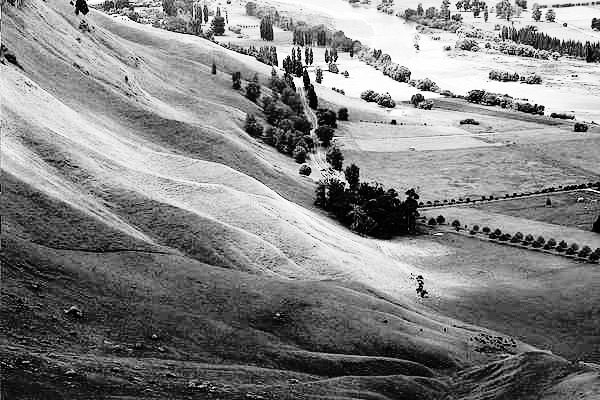

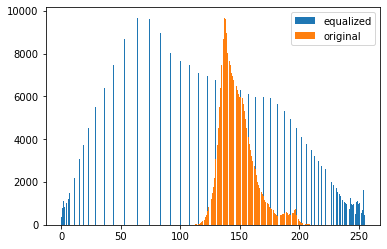

In [37]:
image = np.array(Image.open('data/600x400.png').convert('L'))
seq_with_plotting(image,np.zeros(image.shape))

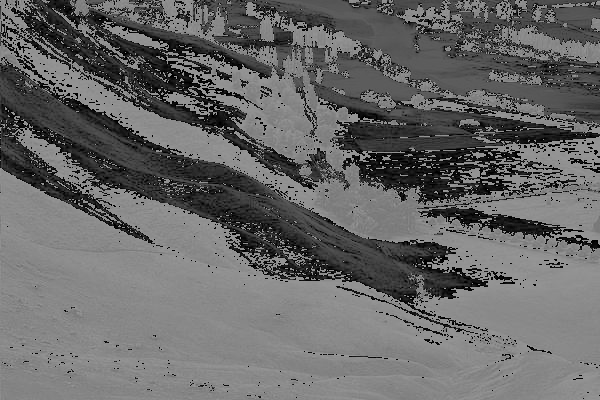

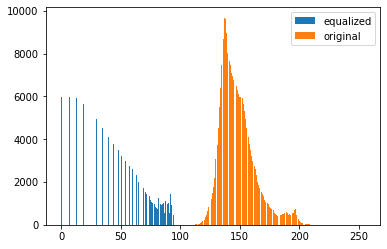

In [38]:
image = np.array(Image.open('data/600x400.png').convert('L'))
mask = np.array(generate_dummy_mask(image,150)) #maska boolowska piksel<150
seq_with_plotting(image,mask)

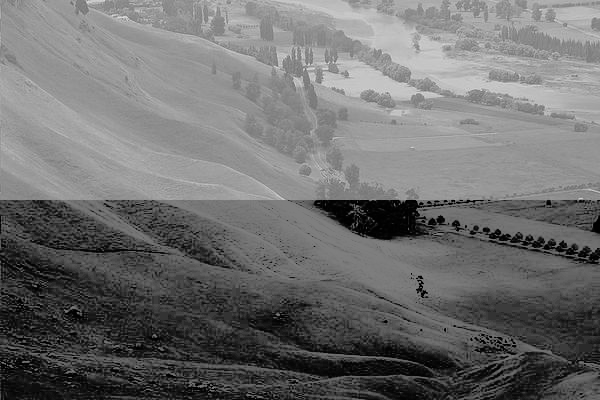

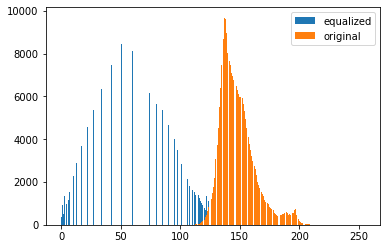

In [39]:
image = np.array(Image.open('data/600x400.png').convert('L'))
mask = np.zeros(image.shape)
for row_id,row in enumerate(mask[:len(mask)//2]):
    mask[row_id]=1
seq_with_plotting(image,mask)

In [41]:
%%timeit -r 5 -n 10
parallel(image,mask,256)

3.87 ms ± 644 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [33]:
%%timeit -r 5 -n 10
sequential(image,mask,256)

1.17 s ± 201 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
